# **Anomaly Detection**

The task is aimed at distinguishing between users who are doing some exercises. In "Activity Recognition from a Single Chest-Mounted Accelerometer" dataset, we have such values as x,y, and z acceleration, 7 types of exercises + 1 unknown type (as zero), and the label of the person.


## **Data preparation**

In the section 1 we import main modules and load data from csv files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate, UpSampling2D
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose,MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GaussianNoise, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

# from thundersvm import SVC
ls = []
for i in range(1,16):
  data = pd.read_csv('%d.csv' % i, names = ["number","x_acceleration","y_acceleration","z_acceleration","label"], sep=',', quotechar='"')
  data_mask = ["x_acceleration","y_acceleration","z_acceleration","label"]
  data = data[data_mask]
  data["person"] = i
  ls.append(data)

Using TensorFlow backend.


Function "*get_person_data*" provides necessary information about a particular person or all people together. 

n -> Person class; 44 is 4 first people data; 15 is data of people all together

pca -> Dimensionality reduction; number of output dinesions of x,y,z accelaration using PCA algorithm
In case pca = 1, there is dimensionality reduction using generalisation of the accelarations like √(x^2 + y^2 + z^2) => accelaration (from [this](https://www.researchgate.net/publication/221258784_Human_Activity_Recognition_from_Accelerometer_Data_Using_a_Wearable_Device) paper)

normalize - Normalazation of the accelaration or pca-given data

In [2]:
def my_function(x,y,z):
  return math.sqrt(math.pow(x,2) + math.pow(y,2) + math.pow(z,2))
  
def get_peson_data(n = 15, pca = False, one_hot = False, normalize = False):
  norm_step = 3
  data = 0
  if n >= 0 and n <= 14:
    data = pd.concat([ls[n]])
  elif n == 44:
    data = pd.concat([ls[0],ls[1],ls[2],ls[3]])
  else:
    data = pd.concat([ls[0],ls[1],ls[2],ls[3],ls[4],ls[5],ls[6],ls[7],ls[8],ls[9],ls[10],ls[11],ls[12],ls[13],ls[14]])
  df = shuffle(data)
  ohe = OneHotEncoder()
  dt = df["person"]
  
  kk = dt.values
  kk = kk.reshape((-1,1))
  ohe.fit(kk)
  if pca == 1:
    df.insert(0, "acceleration", 0.1) 
    df['acceleration'] = np.sqrt(np.power(df.x_acceleration,2) + np.power(df.y_acceleration,2) + np.power(df.z_acceleration,2))
    df = df.drop(["x_acceleration", "y_acceleration", "z_acceleration"], axis=1)
    norm_step = 1
  dt = pd.get_dummies(dt,columns=['person']).values
  x = df.loc[:, :"label"]
  if one_hot:
    x = pd.get_dummies(x,columns=['label'])
  

  x = x.values
  if pca == 3:
    pca = PCA(n_components = 3)
    x = pca.fit(x).transform(x)
  if normalize:
    x_normal = (x - np.min(x, axis = 0)) / (np.max(x, axis = 0) - np.min(x, axis = 0))
    x_normal[:,norm_step:] = x[:,norm_step:]
    x = x_normal
  X_train, X_test, y_train, y_test = train_test_split(x, dt, test_size=0.2, random_state=7)
  return X_train, y_train, X_test, y_test

## Classification models

In this section, I explain the main approaches to this issue and what is the performance of each one.

Moreover, the first step is to get our data for each class or numerous classes. 

The dataset is divided into training and testing parts, 80% and 20% respectively.

The whole idea of classification people basing on the parameters of the movement is a pretty new idea. People somehow are similar to each other, and meanwhile, two people do some exercises, they might repeat the same pattern. That is why the distribution of their data might overlap that will lead to worth classification.

Another issue with the data is that there are too much of them; thus the training of the models (straightforward ML model like RandForest, DTree and Multilayer perceptrons) take much time even with suitable hardware.

The idea of classification leads to precise learning of the movements of the people.

In [3]:
X_train, y_train, X_test, y_test = get_peson_data(15,one_hot = True, normalize = True)
X_train.shape

C:\Users\kolia\AppData\Local\conda\conda\envs\nnets\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1541516, 11)

## Visualization

In [0]:
def display_history(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
def build_ROC_model(predict,X, y, prob = False):
  score = predict(X)
  score = np.array(score)
  print(y.shape)
  print(score.shape)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if prob:
    
    for i in range(15):
      fpr[i], tpr[i], _ = roc_curve(y[:,i], score[i,:,1])
      roc_auc[i] = auc(fpr[i], tpr[i])
  else:
    for i in range(15):
      fpr[i], tpr[i], _ = roc_curve(y[:,i], score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  if prob:
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), score[:,:,1].ravel())
  else:
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
  n_classes = 15
  lw = 2
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(10,10))
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

## LSTM model

After considering different models, I gave a try to LSTM as a reasonable consequence classifier. 

For anomaly detection, the key input is the last one that is why the LSTM model should take into account only the last input to differentiate which person is currently doing the exercise with the device on the chest. 

There have been many models to be tested for this problem. For example, simple LSTM, parallel LSTMs, few LSTMs in a row. Though the best solution came up with the idea of expanding main features by placing Dense layer as the first layer before the LSTM. Instead of giving just input features to LSTM, the model analyze the input, by making the feature vector dimensionality 128  instead of 11 (which leads to more clear identification), and giving it as the input to LSTM layer. There were a few options with 64, 128, 256 and 128 one showed up the best accuracy result.

Also, it was noticed that the best generalization result might be achieved with Dropout only after LSTM layer.

The input data format is best achieved when we normalize the acceleration directions, and one hot encode the type of exercise. 
The best accuracy result is 0.839 on test dataset after 30 epochs of training.

In [0]:
dim = 11
input_image = Input(shape = (dim,))
n = 512

hid = Dense(128, activation='relu')(input_image)
# hid = Dropout(0.2)(hid)

hid = Reshape((1,128))(hid)
hid = LSTM(n)(hid)
# hid = Dropout(0.2)(hid)

# hid = LSTM(n)(hid)
# hid = Dropout(0.2)(hid)

# hid = LSTM(n)(hid)

# hid = Dense(n, activation='relu')(hid)
# hid = Dropout(0.2)(hid)

# hid = Dense(n, activation='relu')(hid)
# hid = Dropout(0.2)(hid)

hid = Dense(15, activation='softmax')(hid)
D = Model(inputs=input_image, outputs=hid)
opt = Adam(0.01)
D.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = D.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 1000)

Train on 1541516 samples, validate on 385380 samples
Epoch 1/10
1541516/1541516 [==============================] - 15s 10us/step - loss: 0.4953 - acc: 0.8308 - val_loss: 0.5731 - val_acc: 0.8023
Epoch 2/10
1541516/1541516 [==============================] - 15s 9us/step - loss: 0.4925 - acc: 0.8321 - val_loss: 0.4941 - val_acc: 0.8325
Epoch 3/10
1541516/1541516 [==============================] - 15s 10us/step - loss: 0.4861 - acc: 0.8342 - val_loss: 0.4836 - val_acc: 0.8362
Epoch 4/10
1541516/1541516 [==============================] - 14s 9us/step - loss: 0.4872 - acc: 0.8335 - val_loss: 0.5257 - val_acc: 0.8248
Epoch 5/10
1541516/1541516 [==============================] - 15s 9us/step - loss: 0.4877 - acc: 0.8331 - val_loss: 0.4780 - val_acc: 0.8379
Epoch 6/10
1541516/1541516 [==============================] - 15s 9us/step - loss: 0.4791 - acc: 0.8359 - val_loss: 0.4736 - val_acc: 0.8389
Epoch 7/10
1541516/1541516 [==============================] - 15s 9us/step - loss: 0.4802 - acc: 0.

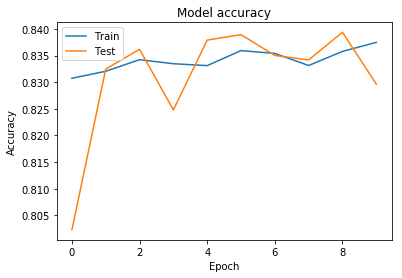

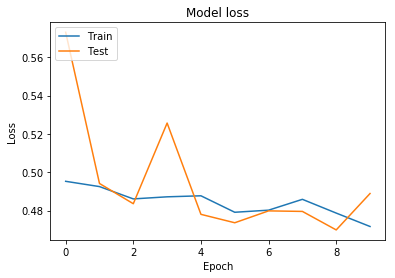

In [31]:
display_history(history)

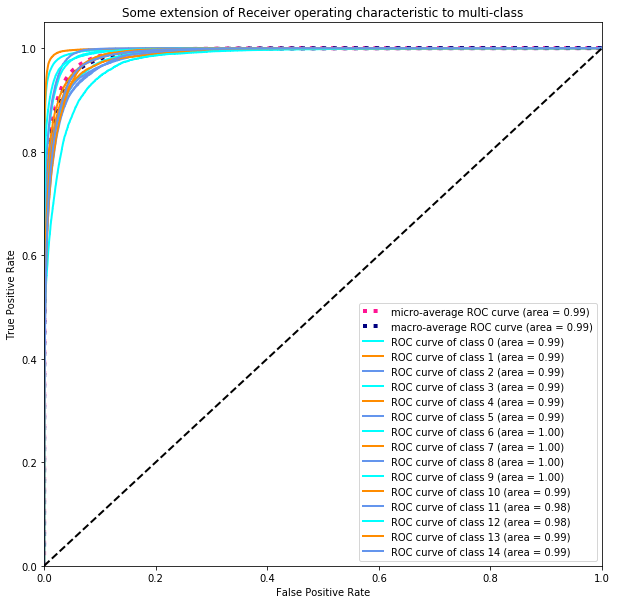

In [39]:
build_ROC_model(D.predict, X_test, y_test)

## Dense multilayer model (DL model)

Multilayer perceptron model is the most typical model when it comes to classification with a big amount of data. The classification is usually done with SVM though there are around 2 million data points that might take an infinite amount of time to calculate the support vectors even in 2-dimensional space.

In such case it is good to apply of the Deep learning models as a multilayer dense model with shape as 1024 => 1024 => 1024 => 1024 => 128 => 15.

The output is 15 as far we have 15 one-hot-encoded people classes.

I have started from 128 dimensions for each layer. Time by time increasing the dimensionality and 1024 option showed much better results than 2048 with test accuracy result of 80%. Moreover, eventually, for the last try, I added the last layer with 128 dimensionalities. That "innovation increased" result by 3 percents to 83%



In [0]:
dim = 11
input_image = Input(shape = (dim,))
n = 1024

hid = Dense(n, activation='relu')(input_image)
# hid = Dropout(0.25)(hid)

hid = Dense(n, activation='relu')(hid)
# hid = Dropout(0.25)(hid)

hid = Dense(n, activation='relu')(hid)
# hid = Dropout(0.25)(hid)

hid = Dense(n, activation='relu')(hid)
# hid = Dropout(0.25)(hid)

hid = Dense(128, activation='relu')(hid)

hid = Dense(15, activation='softmax')(hid)
D_dp = Model(inputs=input_image, outputs=hid)
opt = Adam(0.001)
D_dp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = D_dp.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = 400)

Train on 1541516 samples, validate on 385380 samples
Epoch 1/5
1541516/1541516 [==============================] - 29s 19us/step - loss: 0.5132 - acc: 0.8209 - val_loss: 0.6593 - val_acc: 0.7666
Epoch 2/5
1541516/1541516 [==============================] - 28s 18us/step - loss: 0.5040 - acc: 0.8239 - val_loss: 0.5174 - val_acc: 0.8165
Epoch 3/5
1541516/1541516 [==============================] - 29s 19us/step - loss: 0.4982 - acc: 0.8256 - val_loss: 0.4806 - val_acc: 0.8329
Epoch 4/5
1541516/1541516 [==============================] - 29s 19us/step - loss: 0.4925 - acc: 0.8278 - val_loss: 0.4620 - val_acc: 0.8391
Epoch 5/5
1541516/1541516 [==============================] - 28s 18us/step - loss: 0.4831 - acc: 0.8308 - val_loss: 0.4823 - val_acc: 0.8319


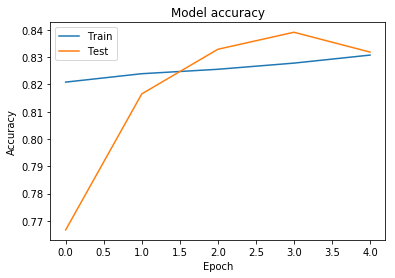

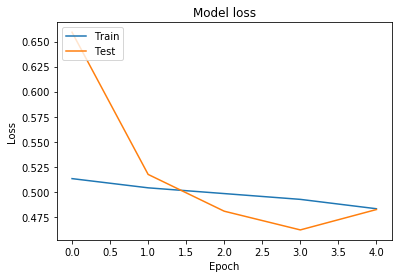

In [40]:
display_history(history)

(385380, 15)
(385380, 15)


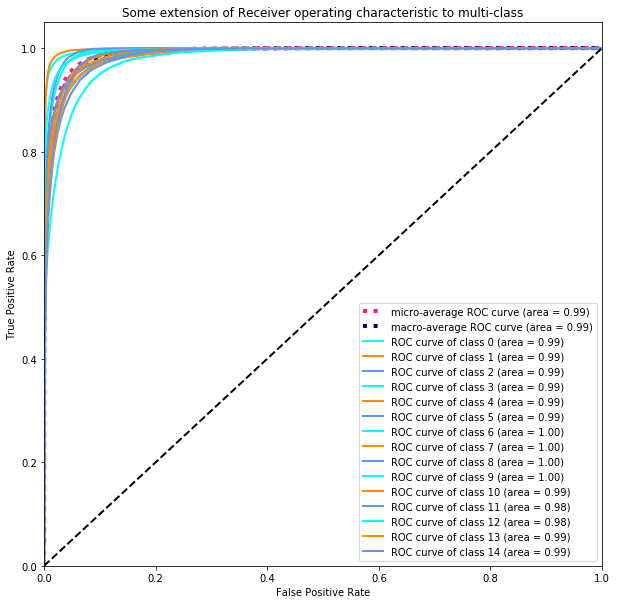

In [70]:
build_ROC_model(D_dp.predict, X_test, y_test)

In [71]:
X_train, y_train, X_test, y_test = get_peson_data(15, normalize =True)
X_train[0]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([0.4534687 , 0.57586123, 0.52296043, 1.        ])

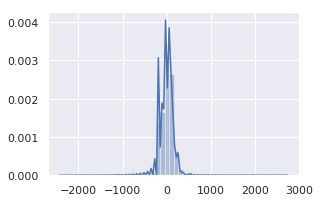

In [72]:
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5,3)})


pca = PCA(n_components = 1)
X_train = pca.fit(X_train).transform(X_train)

ax = sns.distplot(X_train)

## K-nearest neighbors algorithm

Getting started with classification, there are few simple algorithms, and one of them is knn. It allows predicting the class based on the distances to the closest instances of available dataset.

The best approach that emerges was the normalized dataset with the label column (without one-hot). The algorithm shows a good result with a short amount of "fitting" time.

There were numerous attempts to find proper hyperparameter fro number of nearest neighbors (k) and eventually it turned out to be **6**.

Below there is a code written to classify the input data using k = 6. It doesn't take any time to fit data, so it is using it in real-time.

In [122]:
from collections import Counter
import math

def knn(X_data, Y_data, query, k, distance_fn, choice_fn):
    neighbor_distances_and_indices = []
    
    for index, example in enumerate(X_data):
        distance = distance_fn(example[:-1], query)
        neighbor_distances_and_indices.append((distance, index))

    sorted_neighbor_distances_and_indices = sorted(neighbor_distances_and_indices)
    
    k_nearest_distances_and_indices = sorted_neighbor_distances_and_indices[:k]
    
    k_nearest_labels = [Y_data[i] for distance, i in k_nearest_distances_and_indices]

    return k_nearest_distances_and_indices , np.array(choice_fn(k_nearest_labels))

def mean(labels):
    return sum(labels) / len(labels)

def mode(labels):
    return Counter(labels).most_common(1)[0][0]

def euclidean_distance(point1, point2):
    sum_squared_distance = 0
    for i in range(len(point1)):
        sum_squared_distance += math.pow(point1[i] - point2[i], 2)
    return math.sqrt(sum_squared_distance)

  
reg_query = X_train[5]
reg_k_nearest_neighbors, reg_prediction = knn(
    X_train, y_train, reg_query, k=6, distance_fn=euclidean_distance, choice_fn=mean
)
print(reg_prediction)
print(y_train[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


Though the code works not as fast as sklearn one. So, for prodcution it will be more approriate to use sklearn KNeighborsClassifier. It takes some time prefit data into model to confiure the distance matrix.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train) 


In [120]:
print(y_test[0])
neigh.predict(X_test[0].reshape((1,-1)))[0]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [128]:
neigh.score(X_test, y_test)

0.8180912346255643

(385380, 15)
(15, 385380, 2)


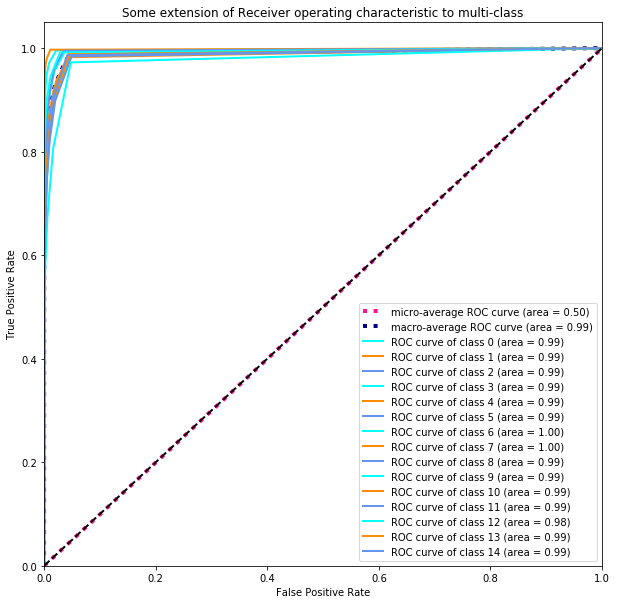

In [117]:
build_ROC_model(neigh.predict_proba, X_test, y_test, prob = True)

## Autoencoder

One of the key ideas that I have found out on the Internet was to use the Autoencoders to classify either it is a value from this class or not.

So basically the autoencoder has learned the output value of let`s say first class, and the loss of the output is miserably small. However, if we give the value of the second class to the autoencoder => the loss will be much more significant than the original class value. Such a solution ideally fits into the anomaly detection problem. 
We sequently measure the loss of each autoencoder regarding given input and take the index of minimum value as the predicted class.
Moreover, it works perfectly for most of the given classes.

Though the main issue was that few of the distributions of classes are overlapping too many other classes, so their autoencoders dominate over other classifying autoencoders. In this case, the data of person 6 and 13 are copying too many patterns from other people behavior. So their autoencoders give out the least loss during the identification.

In [263]:
X_train, y_train, X_test, y_test = get_peson_data(15, one_hot = True,normalize =True)
X_train[0]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([0.51325437, 0.56022477, 0.4938935 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        ])

In [0]:
from keras import regularizers
def get_trained_autoencoder(d, d_test):
  input_img = Input(shape=(11,))

  encoded = Dense(256, activation='tanh', activity_regularizer=regularizers.l1(0.005))(input_img)
  encoded = Dropout(0.5)(encoded)

  encoded = Dense(128, activation='tanh')(encoded)
  encoded = Dropout(0.5)(encoded)

  encoded = Dense(64, activation='tanh')(encoded)
  encoded = Dropout(0.5)(encoded)

  encoded = Dense(128, activation='tanh')(encoded)
  encoded = Dropout(0.5)(encoded)

  encoded = Dense(256, activation='tanh')(encoded)
  encoded = Dropout(0.5)(encoded)



  decoded = Dense(11, activation='sigmoid')(encoded)

  autoencoder = Model(input_img, decoded)
  
  adam = Adam(0.005)
  autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
  
  autoencoder.fit(d, d,
                epochs=10,
                batch_size=200,
                validation_data = (d_test,d_test)
                )
  return autoencoder

I have tried dozens of different architectures and afterwards, the tanh activation function showed better results than relu function; Droputs helped generalize data better on test dataset.
And the mean-squared loss is used to identify how bad is the result summing up all the losses for each output node.

In [0]:
def autoencoder_predict(a_encoders, X):
  pr = []
  print(X.shape[0])
  for i in range(X.shape[0]):
    n = X[i,:].reshape((-1,11))
    pred = []
    for i in range(len(a_encoders)):
      preriction = a_encoders[i].predict(n)
      res = np.sum(np.absolute(n - preriction))
      pred.append(res)
    pred = np.array(pred)
    
    mx = np.argmin(pred)
    print(mx)
    pred = np.zeros(15)
    pred[mx] = 1
    pr.append(pred)
  return np.array(pr)

In [320]:
X_train1, y_train1, X_test1, y_test1 = get_peson_data(7, one_hot = True,normalize =True)
X_train1[0]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([0.31525424, 0.43470353, 0.48790618, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [0]:
X_train, y_train, X_test, y_test = get_peson_data(1, one_hot = True,normalize =True)
autoencoder = get_trained_autoencoder(X_train, X_test)

Here you can see how good it works, if we train autoencoder using person 1 data and then applying loss measure to data of person number 2.

Incorrect values coreespond to losses of person 2 and Correct to person number 1. The loss for incrrect inputs is around 0.5 meanwhile the loss of correct inputs is less than 0.05. This test shows the significant separation between the results of two classes.

Incorrect
0.5153773265332535
0.5971996444536041
0.5126846764463387
0.415226238911587
0.6495611359506019
0.42774063042997384
0.5245213347567568
0.5639971081723427
0.569231352937421
0.4390501369164232


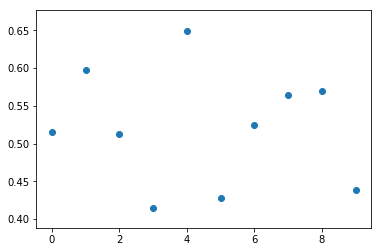

Correct
0.033936620055354194
0.03148566330558644
0.045797712898969445
0.03204901896510737
0.03225711235402329
0.024106947252303
0.026861132112909192
0.016282469225481655
0.03604016018939499
0.0502297923319705


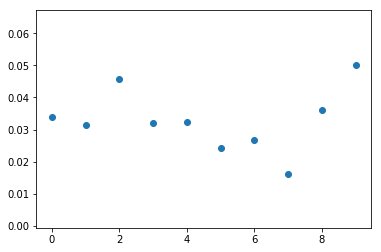

In [174]:
make_predictions()

Here we train 15 autoencoder for each class data.

As you see from predictions, the autoencoder number 7 can not learn properly the data and therefore does not gve small loss during classification.

In [0]:
a_encoders = []

for i in range(15):
  print(i,'-----------------')
  X_train, y_train, X_test, y_test = get_peson_data(i, one_hot = True,normalize =True)
  ate = get_trained_autoencoder(X_train,X_test)
  a_encoders.append(ate)

In [0]:
X_train1, y_train1, X_test1, y_test1 = get_peson_data(7, one_hot = True,normalize =True)
X_train1[0]

In [319]:
predictions = autoencoder_predict(a_encoders, X_test1[0:5])



5
6
6
6
6
6


In [0]:
y_test1[3]

In [257]:
metrics.accuracy_score(y_test[0::50], predictions)

0.0743383497664764

In [311]:
a_encoders[3].fit(X_train1, X_train1,
              epochs=5,
              batch_size=200,
              validation_data = (X_test1,X_test1)
              )

Train on 97760 samples, validate on 24441 samples
Epoch 1/5
97760/97760 [==============================] - 4s 37us/step - loss: 0.0837 - acc: 0.9341 - val_loss: 0.0790 - val_acc: 0.9838
Epoch 2/5
97760/97760 [==============================] - 4s 39us/step - loss: 0.0993 - acc: 0.9289 - val_loss: 0.0926 - val_acc: 0.9838
Epoch 3/5
97760/97760 [==============================] - 4s 38us/step - loss: 0.1089 - acc: 0.9272 - val_loss: 0.1333 - val_acc: 0.9838
Epoch 4/5
97760/97760 [==============================] - 4s 40us/step - loss: 0.1125 - acc: 0.9378 - val_loss: 0.1192 - val_acc: 0.9838
Epoch 5/5
97760/97760 [==============================] - 4s 39us/step - loss: 0.1165 - acc: 0.9396 - val_loss: 0.1457 - val_acc: 0.9838


In [214]:

for n in range(10000):
  if n % 997 == 0:
    e = n
    pred = []
    elem = X_test1[e].reshape((-1,11))
    for i in range(len(a_encoders)):
      preriction = a_encoders[i].predict(elem)
      res = np.sum(np.absolute(elem - preriction))
      pred.append(res)
    pred = np.array(pred)
#     print(pred)
    print(np.argmin(pred))
#     print(dt[e])

4
2
11
4
4
4
4
7
2
2
2


In [0]:
def make_predictions():
  print('Incorrect')
  ee = []

  for e in range(30000):
    if e % 3000 == 0:
      res = np.sum(np.absolute(X_train1[e] - autoencoder.predict(X_train1[e].reshape((-1,11)))))
      ee.append(res)
      print(res)

  line = range(len(ee))

  plt.scatter(line, ee)
  plt.show()
  
  print('Correct')
  ee = []

  for e in range(30000):
    if e % 3000 == 0:
      res = np.sum(np.absolute(X_train[e] - autoencoder.predict(X_train[e].reshape((-1,11)))))
      ee.append(res)
      print(res)

  line = range(len(ee))

  plt.scatter(line, ee)
  plt.show()

  

### SVM

SVM does not work for this dataset as far it is around 1 million. And the best dataset for SVM is less than 10000.

I have tried with different action function, reducing dimensions of input data. Though it stuck fitting for hours :(

In [0]:
SVM = svm.SVC(kernel = 'linear')
SVM.fit(X_train, y_train)

## Random Forest And Decision Tree

Unpredictably, good results were shown by Randon forest (with 20 estimators) giving the AUC up to 0.99 per each class.
RF result with 10 estimators was around 0.75 on the training set. Also, when I raised the number, it increased by 5 percent. But it takes a lot of time to fit in the data. That is why the result with 100 estimators might be much better

Decision Tree has given the same accuracy on the whole dataset (around 0.8). Though the AUC is much less per each class (around 0.85-0.9)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 20)

rf.fit(X_train, y_train)

In [123]:
rf.score(X_test, y_test)


0.8069204421609839

(385380, 15)
(15, 385380, 2)


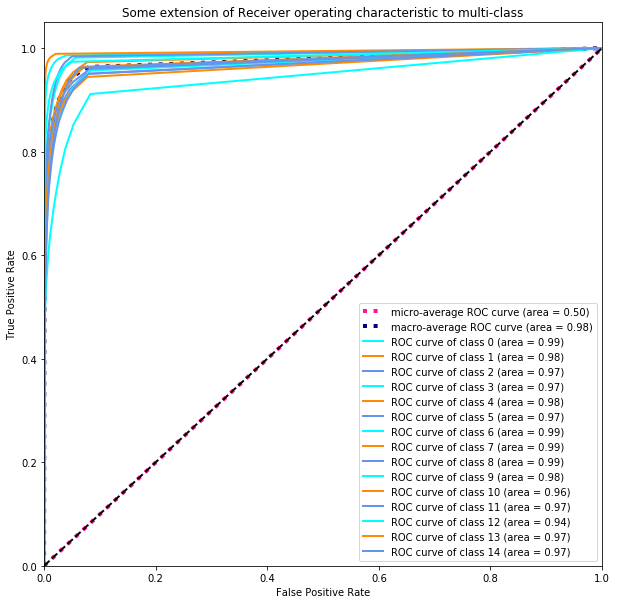

In [124]:
build_ROC_model(rf.predict_proba, X_test, y_test, prob = True)

In [0]:


clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [126]:
metrics.accuracy_score(y_test, y_pred)

0.8048186205822824

(385380, 15)
(15, 385380, 2)


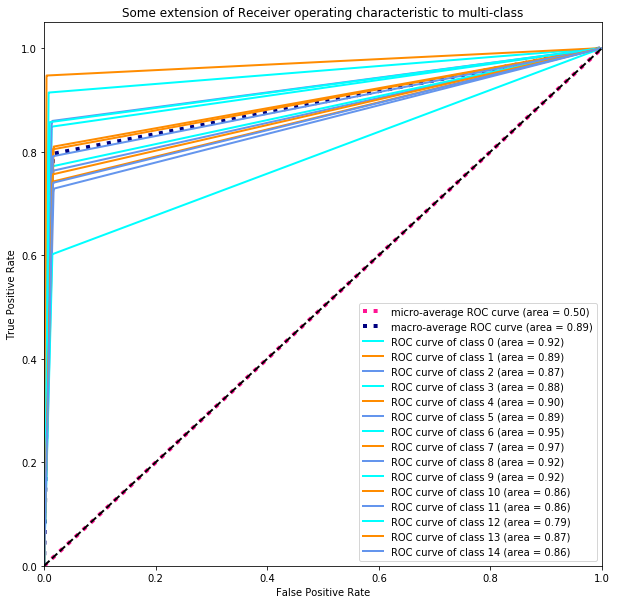

In [127]:
build_ROC_model(clf.predict_proba, X_test, y_test, prob = True)

## Conclusion

Though all researc